In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from pulp import LpProblem, LpMaximize, LpVariable, lpSum
import matplotlib.pyplot as plt

In [23]:
# _processed 파일 불러오기
grid = pd.read_csv("../data/processed/grid_system_processed.csv")
charging = pd.read_csv("../data/processed/charging_stations_processed.csv")
ev = pd.read_csv("../data/processed/ev_registration_processed.csv")
commercial = pd.read_csv("../data/processed/commercial_facilities_processed.csv")

In [24]:
df = grid.copy()
df['facility_count'] = np.random.randint(10, 100, len(df))
df['charging_station_count'] = np.random.randint(0, 20, len(df))
df['registered_vehicles'] = np.random.randint(100, 1000, len(df))

In [25]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['center_lat', 'center_lon']])

In [26]:
features = ['supply_score', 'facility_count', 'charging_station_count', 'registered_vehicles']
target = 'demand_score'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))


MAE: 188.84071187441427
RMSE: 388.4649593138933
R²: -0.032444385229416506


In [28]:
from tqdm import tqdm
from pulp import LpProblem, LpMaximize, LpVariable, lpSum
import numpy as np

# tqdm 설정
tqdm.pandas()

coverage_radius = 0.02  # 약 2km
sites = list(df.index)
demand_points = list(df.index)

# tqdm 적용된 coverage_matrix 계산
coverage_matrix = {}
for i in tqdm(sites, desc="커버리지 매트릭스 구성 중"):
    coverage_matrix[i] = [
        j for j in demand_points
        if np.sqrt((df.loc[i, 'center_lat'] - df.loc[j, 'center_lat'])**2 + 
                   (df.loc[i, 'center_lon'] - df.loc[j, 'center_lon'])**2) <= coverage_radius
    ]

# 최적화 문제 정의
prob = LpProblem("Maximize_Coverage", LpMaximize)
x = LpVariable.dicts('Site', sites, 0, 1, cat='Binary')
y = LpVariable.dicts('Demand', demand_points, 0, 1, cat='Binary')

max_sites = 10
prob += lpSum([y[j] for j in demand_points])
prob += lpSum([x[i] for i in sites]) <= max_sites

# tqdm 적용된 제약조건 생성
for j in tqdm(demand_points, desc="제약 조건 생성 중"):
    prob += y[j] <= lpSum([x[i] for i in sites if j in coverage_matrix[i]])

# 최적화 수행
prob.solve()

selected_sites = [i for i in sites if x[i].varValue == 1]
print("선정된 입지 grid_id:", df.loc[selected_sites, 'grid_id'].tolist())


제약 조건 생성 중: 100%|██████████| 5963/5963 [00:12<00:00, 481.45it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/a28af090d4804132bbfb24241a497390-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/a28af090d4804132bbfb24241a497390-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5969 COLUMNS
At line 338312 RHS
At line 344277 BOUNDS
At line 356204 ENDATA
Problem MODEL has 5964 rows, 11926 columns and 302527 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 510 - 0.34 seconds
Cgl0004I processed model has 5964 rows, 11926 columns (11926 integer (11926 of which binary)) and 302527 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc00

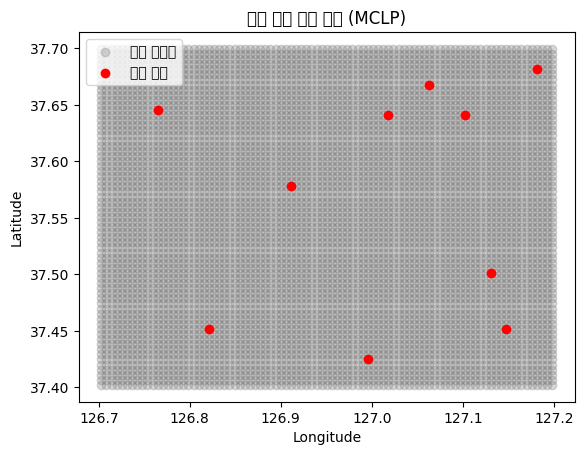

In [29]:
plt.scatter(df['center_lon'], df['center_lat'], c='gray', alpha=0.3, label='전체 그리드')
plt.scatter(df.loc[selected_sites, 'center_lon'], df.loc[selected_sites, 'center_lat'], c='red', label='선정 입지')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("최적 입지 선정 결과 (MCLP)")
plt.legend()
plt.show()